## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from time import time
from tqdm import tqdm, tqdm_notebook


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

## CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
device = torch.device('cuda' if train_on_gpu else 'cpu')

## Load data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
trainset = datasets.MNIST('files/trainset', download=True, train=True, transform=transform)
testset = datasets.MNIST('files/testset', download=True, train=False, transform=transform)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

## Look at the data

In [7]:
images, labels = iter(trainloader).next()

In [8]:
images.shape

torch.Size([32, 1, 28, 28])

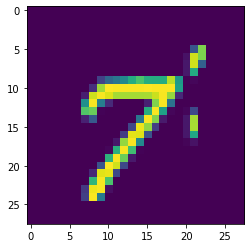

In [9]:
plt.imshow(images[0].numpy().squeeze())

In [18]:
labels[0]

tensor(1)

## Define network

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool0 = nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv1_drop = nn.Dropout2d()
        
        self.fc0 = nn.Linear(in_features=1024, out_features=128)
        self.fc1 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        c0 = F.relu(self.pool0(self.conv0(x)))
        c1 = F.relu(self.pool1(self.conv1_drop(self.conv1(c0))))
        
        fl = c1.view(-1, 1024)
        
        f0 = F.relu(self.fc0(fl))
        f1 = F.dropout(f0, training=self.training)
        f2 = self.fc1(f1)
        return F.log_softmax(f2)

## Training

In [12]:
random_seed = 23
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [17]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    val_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu()
            val_loss = loss_fn(Y_hat, Y_val)
            val_losses.append(val_loss)

        # Visualize tools        
        
    return val_losses

In [18]:
model = Net().to(device)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [19]:
print(model)

Net(
  (conv0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout2d(p=0.5, inplace=False)
  (fc0): Linear(in_features=1024, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
losses = train(model=model, opt=optimizer, loss_fn=criterion, epochs=15, data_tr=trainloader, data_val=testloader)

  0%|          | 0/1875 [00:00<?, ?it/s]

* Epoch 1/15


/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.480197
* Epoch 2/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.157880
* Epoch 3/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.122557
* Epoch 4/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.103893
* Epoch 5/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.090392
* Epoch 6/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.079172
* Epoch 7/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.073527
* Epoch 8/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.067608
* Epoch 9/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.062550
* Epoch 10/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.060086
* Epoch 11/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.057682
* Epoch 12/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.053950
* Epoch 13/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.051715
* Epoch 14/15


  0%|          | 0/1875 [00:00<?, ?it/s]

loss: 0.049190
* Epoch 15/15


100%|██████████| 1875/1875 [00:27<00:00, 67.98it/s]

loss: 0.047127


## Results of training

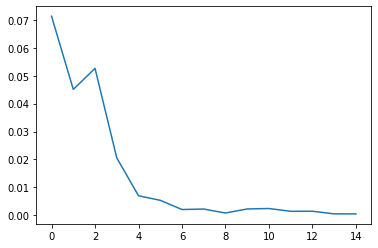

In [21]:
plt.plot(losses)

## Testing

In [22]:
def test(model, testloader):
    accuracy = 0.
    count_all = 0
    for X_val, Y_val in testloader:
        count_all += len(Y_val)
        Y_pred = model(X_val.to(device))
        Y_pred = torch.argmax(Y_pred, 1).to('cpu')
        true_predicted = (Y_pred == Y_val).sum()
        accuracy += true_predicted
    accuracy /= count_all
    return accuracy.numpy().item()

In [23]:
acc = test(model, testloader)

/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [24]:
print('accuracy: {:.3f}%'.format(acc*100))

accuracy: 99.310%


## Visualize

In [25]:
X_val, Y_val = next(iter(testloader))
Y_pred = model(X_val.to(device))
Y_pred = torch.argmax(Y_pred, 1)

/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: Colormap grayscale is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

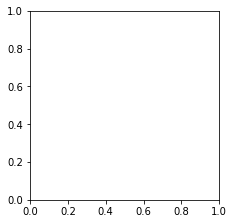

In [26]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_val[i].numpy().squeeze(), cmap='grayscale')
    plt.title('real: {}, predicted: {}'.format(Y_val[i].item(), Y_pred[i].item()))
plt.show()